# Diode Bridge

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.  
It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool, cpu_count
from PySpice.Spice.Netlist import (
    Circuit, SubCircuitFactory
)
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Introduction

A **diode bridge** is a **rectifier circuit** that converts an **alternating voltage** (which alternates between positive and negative values) into a **unidirectional voltage** that is either entirely positive or entirely negative.
This circuit is also known as a **Graetz bridge** or simply a **rectifier circuit**.

On its own, a diode bridge is not particularly useful — it is typically combined with other components such as a **resistor** and a **capacitor** (in parallel) to form an **AC–DC converter**, which provides a smooth DC voltage from an AC source.

However, the diode bridge can also serve as an **autonomous protection circuit**.
For example, when a system must maintain a specific polarity (e.g., +10 V), and there is a risk of connecting a –10 V source by mistake, the bridge ensures that the **output polarity remains correct**, thus protecting the following components.

## Circuit

```{figure} ./images/pont_diode_circuit.svg
:name: pont_diode_circuit
:align: center
:width: 500px

Electrical schematic of a diode bridge circuit
```

The circuit shown above consists of **four diodes** arranged **symmetrically**.
Both the input and output have **two terminals**:

* The **input** is typically connected to an **AC source**.
* The **output** delivers a **rectified voltage**, which remains positive (or negative) depending on the configuration.

## Operating Principle

The operation of the diode bridge can be analyzed in **two main cases**:

1. When the **input voltage** is **below** the **diode threshold voltage** ($V_\text{seuil}$):
   The diodes **do not conduct**, and no current flows through the load.

2. When the **input voltage** is **above** $V_\text{seuil}$:
   The diodes start to **conduct in pairs**, allowing current to flow **in the same direction** through the load, regardless of the input polarity.

This results in a **rectified output**, where both halves of the input AC waveform are converted into a **unidirectional (pulsating DC)** voltage.

### Case 1: $V_e > V_{\text{seuil}}$

When the input voltage $V_e$ is **greater** than the threshold voltage $V_{\text{seuil}}$, as shown in the [](#pont_diode_circuit_cas_1), **two diodes conduct** (acting as short circuits), while the other two remain **blocked** (open circuits).

As a result, the output voltage satisfies:

$$
V_s = V_e
$$

```{figure} ./images/pont_diode_circuit_cas_1.svg
:name: pont_diode_circuit_cas_1
:align: center
:width: 500px

Electrical schematic of the diode bridge – Case 1
```

### Case 2: $V_e < -V_{\text{seuil}}$

In this case, as shown in the [](#pont_diode_circuit_cas_2) and similarly to [Case 1](#pont_diode_circuit_cas_1), two diodes are **conducting** and two are **blocked**.
However, the current now flows through the **opposite pair** of diodes.

By observing the schematic, we can see that:

$$
V_s = -V_e
$$

```{figure} ./images/pont_diode_circuit_cas_2.svg
:name: pont_diode_circuit_cas_2
:align: center
:width: 500px

Electrical schematic of the diode bridge – Case 2
```

Thus, in both cases, the output voltage $V_s$ remains **positive**, regardless of the polarity of $V_e$.


### Case 3: $-V_{\text{seuil}} < V_e < V_{\text{seuil}}$

When the input voltage $V_e$ lies **between** $-V_{\text{seuil}}$ and $V_{\text{seuil}}$, neither pair of diodes conducts — both remain in a **blocked** state.
As a result, **no current flows** through the circuit.

This situation is represented in the [](#pont_diode_circuit_cas_3).
Therefore, the output voltage is:

$$
V_s = 0
$$

```{figure} ./images/pont_diode_circuit_cas_3.svg
:name: pont_diode_circuit_cas_3
:align: center
:width: 500px

Electrical schematic of the diode bridge – Case 3
```

### Summary

|  Case | Input Voltage                                  | Conducting Diodes        | Output Voltage |
| :---: | :--------------------------------------------- | :----------------------- | :------------- |
| **1** | $V_e > V_{\text{seuil}}$                       | Two (forward conduction) | $V_s = V_e $   |
| **2** | $V_e < -V_{\text{seuil}}$                      | Two (opposite pair)      | $V_s = -V_e$   |
| **3** | $-V_{\text{seuil}} < V_e < V_{\text{seuil}}$   | None                     | $V_s = 0$      |

In summary, the **diode bridge** ensures that the **output voltage is always positive**, regardless of the **input polarity**.
This property makes it an essential element in **rectifier circuits** and **polarity protection systems**.

## Simulation

The objective of this section is to **build the diode bridge circuit** and then perform **simulations** to better understand its operation.
We start with the model shown in the [](#model_spice).

```{figure} ./images/pont_diode_circuit_spice.svg
:name: model_spice
:align: center
:width: 500px

SPICE model of the diode bridge circuit
```

In the schematic above, we can see the **diode bridge** just as we previously constructed it.
The circuit includes **four nodes**:

* **Input terminals:** `in_plus` and `in_min`
* **Output terminals:** `out_plus` and `out_min`

Additionally, the **voltage source** is represented by `Vinput`.

However, two **extra resistors** appear in the SPICE model that were **not present** in the original circuit diagram (cf. [](#pont_diode_circuit)):

1. **`Rload`** — the **load resistor**, representing the external circuit connected to the bridge output.
   Its purpose is to simulate the **behavior of the connected load** and observe how it affects the output voltage and current.

2. **`Rref`** — the **reference resistor**, which is **essential for simulation stability**.
   Without it, the circuit would lack a proper reference node, causing all node voltages to **float**, which prevents the simulator from performing valid calculations.

```{note}
The `Rref` resistor must be **very large** to ensure that only a **negligible leakage current** flows through it, minimizing any influence on the circuit’s normal operation.
```

Once the model is defined, we can proceed to **run the simulation**, analyze the **voltage and current waveforms**, and compare them to the **theoretical behavior** described earlier.

In [54]:
# ---------------------------------------------------------
# Circuit Definition
# ---------------------------------------------------------
circuit = Circuit('Full-Wave Bridge Rectifier (1N4004)')

# Include the diode model library
circuit.include('lib/diodes_standard-rectifiers.lib')

# AC input source (10 V amplitude, 50 Hz)
circuit.SinusoidalVoltageSource('input', 'in_plus', 'in_min', amplitude=10@u_V, frequency=50@u_Hz)

# Reference to ground (important for simulation)
circuit.R('ref', 'in_min', circuit.gnd, 1@u_mΩ)

# Bridge diodes
circuit.D('D1', 'in_plus',   'out_plus',  model='DI_1N4004GL')
circuit.D('D2', 'out_min', 'in_plus',   model='DI_1N4004GL')
circuit.D('D3', 'in_min',  'out_plus',  model='DI_1N4004GL')
circuit.D('D4', 'out_min', 'in_min',  model='DI_1N4004GL')

# Load resistor
circuit.R('load', 'out_plus', 'out_min', 1@u_kΩ)

.title Full-Wave Bridge Rectifier (1N4004)
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\General\lib\diodes_standard-rectifiers.lib
Vinput in_plus in_min DC 0V AC 1V SIN(0V 10V 50Hz 0s 0Hz)
Rref in_min 0 1mOhm
DD1 in_plus out_plus DI_1N4004GL
DD2 out_min in_plus DI_1N4004GL
DD3 in_min out_plus DI_1N4004GL
DD4 out_min in_min DI_1N4004GL
Rload out_plus out_min 1kOhm



In [55]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=0.1@u_ms, end_time=40@u_ms)

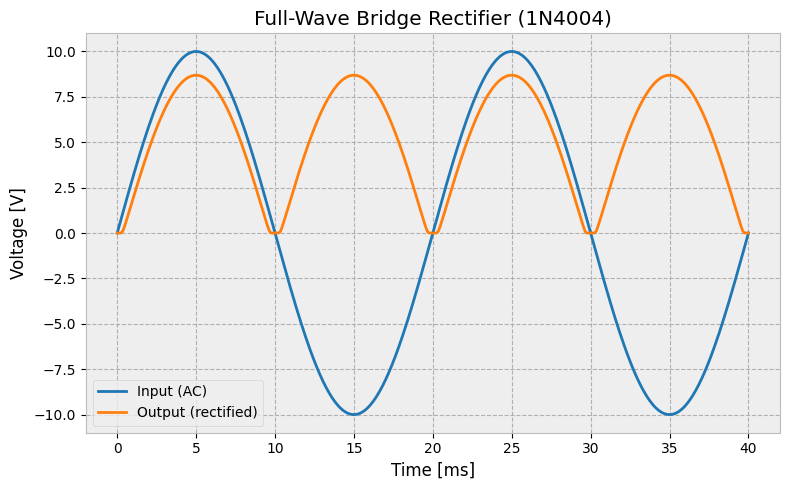

In [56]:
# Plot input and output voltage
plt.figure(figsize=(8,5))
plt.plot(analysis.time*1000, analysis['in_plus'], label='Input (AC)')
plt.plot(analysis.time*1000, analysis['out_plus'] - analysis['out_min'], label='Output (rectified)')
plt.title('Full-Wave Bridge Rectifier (1N4004)')
plt.xlabel('Time [ms]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Simulation Results and Analysis

The **input signal** varies between **–10 V** and **+10 V**, as expected.
However, the **output signal** only varies between **0 V** and approximately **8.7 V**.

We can observe that the **output voltage does not reach 10 V**.
This difference can be explained by the **voltage drops** across the **two conducting diodes** in the bridge during each half-cycle.
Each diode introduces a drop of roughly **0.7 V**, which gives:

$$
V_{\text{out}} \approx V_{\text{in}} - 2 \times 0.7 = 10 - 1.4 = 8.6~\text{V}
$$

This theoretical value closely matches the **8.7 V** measured in the simulation output.

Furthermore, when the **input signal becomes negative**, the **output signal remains positive** — confirming the rectifying function of the diode bridge.

Finally, we can notice the presence of a **dead zone** around zero volts.
As discussed in the previous section, this occurs when the input voltage lies between $-V_{\text{seuil}}$ and $V_{\text{seuil}}$, meaning none of the diodes conduct.

In the **next section**, we will focus on **analyzing and reducing this dead zone** to improve the quality of the rectified signal.

In [1]:
# ---------------------------------------------------------
# Circuit Definition
# ---------------------------------------------------------
circuit = Circuit('Full-Wave Bridge Rectifier (1N4004)')

# Include the diode model library
circuit.include('lib/diodes_standard-rectifiers.lib')

# AC input source (10 V amplitude, 50 Hz)
circuit.SinusoidalVoltageSource('input', 'in_plus', 'in_min', amplitude=1.5@u_V, frequency=50@u_Hz)

# Reference to ground (important for simulation)
circuit.R('ref', 'in_min', circuit.gnd, 1@u_mΩ)

# Bridge diodes
circuit.D('D1', 'in_plus',   'out_plus',  model='DI_1N4004GL')
circuit.D('D2', 'out_min', 'in_plus',   model='DI_1N4004GL')
circuit.D('D3', 'in_min',  'out_plus',  model='DI_1N4004GL')
circuit.D('D4', 'out_min', 'in_min',  model='DI_1N4004GL')

# Load resistor
circuit.R('load', 'out_plus', 'out_min', 1@u_kΩ)

NameError: name 'Circuit' is not defined

In [61]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=0.1@u_ms, end_time=40@u_ms)

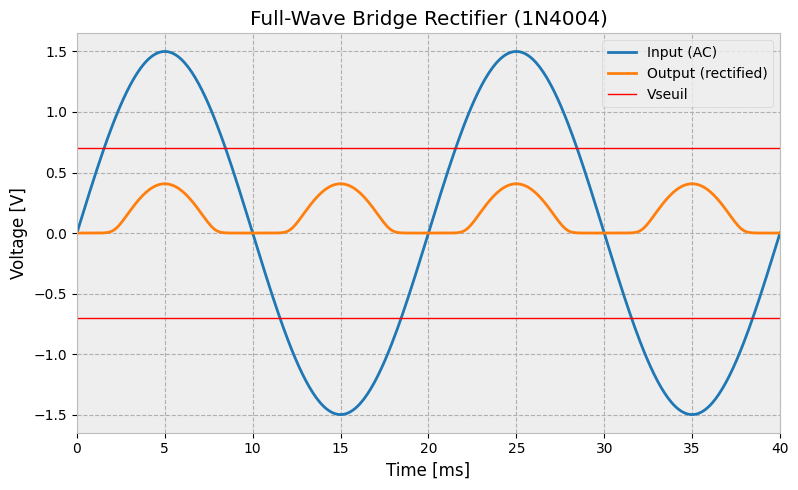

In [69]:
# Plot input and output voltage
plt.figure(figsize=(8,5))
plt.plot(analysis.time*1000, analysis['in_plus'], label='Input (AC)')
plt.plot(analysis.time*1000, analysis['out_plus'] - analysis['out_min'], label='Output (rectified)')
plt.axhline(y=0.7, color="red", label="Vseuil", lw=1)
plt.axhline(y=-0.7, color="red", lw=1)
plt.title('Full-Wave Bridge Rectifier (1N4004)')
plt.xlabel('Time [ms]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 40)
plt.show()

### Dead Zone Behavior

When the **input signal** (blue curve) is between **–0.7 V** and **+0.7 V**, the **output signal** remains approximately **0 V**.
This corresponds to the **non-conduction region** of the diodes in the bridge.

Once the **input voltage exceeds the threshold** of ±0.7 V, the **output signal begins to rise**, following the rectified behavior of the bridge.

In most applications, this effect is **negligible**, but it is important to **consider carefully when dealing with small signals**, as the dead zone can significantly affect the response.

## Effet aute fréquence - temps de monté

Il faut faire attention avec les diodes et c'est pour le temps de monté, car si la fréquence des changements est trop rapide alors les diodes ne peuvent plus suivre le temps de monté. 

Pour faire cela nous allons changer la fréquence du système

In [70]:
frequency=100
step_time=100
end_time=50

In [78]:
# ---------------------------------------------------------
# Circuit Definition
# ---------------------------------------------------------
circuit = Circuit('Full-Wave Bridge Rectifier (1N4004)')

# Include the diode model library
circuit.include('lib/diodes_standard-rectifiers.lib')

# AC input source (10 V amplitude, 50 Hz)
circuit.SinusoidalVoltageSource('input', 'in_plus', 'in_min', amplitude=5@u_V, frequency=frequency@u_MHz)

# Reference to ground (important for simulation)
circuit.R('ref', 'in_min', circuit.gnd, 1@u_mΩ)

# Bridge diodes
circuit.D('D1', 'in_plus',   'out_plus',  model='DI_1N4004GL')
circuit.D('D2', 'out_min', 'in_plus',   model='DI_1N4004GL')
circuit.D('D3', 'in_min',  'out_plus',  model='DI_1N4004GL')
circuit.D('D4', 'out_min', 'in_min',  model='DI_1N4004GL')

# Load resistor
circuit.R('load', 'out_plus', 'out_min', 1@u_kΩ)

.title Full-Wave Bridge Rectifier (1N4004)
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\General\lib\diodes_standard-rectifiers.lib
Vinput in_plus in_min DC 0V AC 1V SIN(0V 5V 100MegHz 0s 0Hz)
Rref in_min 0 1mOhm
DD1 in_plus out_plus DI_1N4004GL
DD2 out_min in_plus DI_1N4004GL
DD3 in_min out_plus DI_1N4004GL
DD4 out_min in_min DI_1N4004GL
Rload out_plus out_min 1kOhm



In [79]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=step_time@u_ps, end_time=end_time@u_ns)

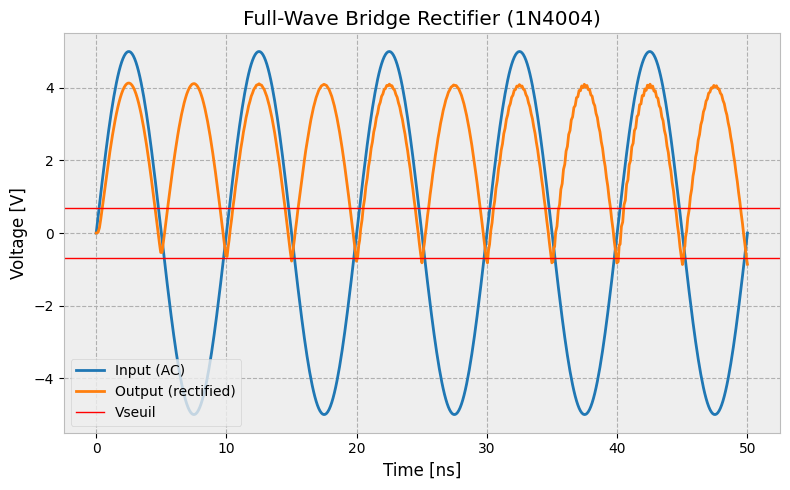

In [81]:
# Plot input and output voltage
plt.figure(figsize=(8,5))
plt.plot(analysis.time*1e9, analysis['in_plus'], label='Input (AC)')
plt.plot(analysis.time*1e9, analysis['out_plus'] - analysis['out_min'], label='Output (rectified)')
plt.axhline(y=0.7, color="red", label="Vseuil", lw=1)
plt.axhline(y=-0.7, color="red", lw=1)
plt.title('Full-Wave Bridge Rectifier (1N4004)')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

It can be observed that the output waveform is not as stable as in the first example. The output voltage occasionally drops below 0 V, and the flat zero-level region has disappeared. In addition, the positive peaks are not clean and appear noisy and distorted.

This behavior can be explained by examining the diode model used:

```text
*SRC=1N4004GL;DI_1N4004GL;Diodes;Si;  400V  1.00A  2.00us   Diodes Inc. Glass Passivated Rectifier
.MODEL DI_1N4004GL D  ( IS=65.4p RS=42.2m BV=400 IBV=5.00u
+ CJO=14.8p  M=0.333 N=1.36 TT=2.88u )
```

Two parameters are particularly important at high frequencies:

- **Transit time (`TT = 2.88 µs`)** – This value is extremely large compared to the input period at high frequencies (for example, 100 MHz corresponds to a 10 ns period). Such a long transit time means the diode cannot switch on or off fast enough, leading to distorted transitions, delayed conduction, and noisy peaks.
- **Zero-bias junction capacitance (`CJO = 14.8 pF`)** – At high frequencies, this capacitance provides an alternate AC path through the junction, causing waveform deformation, partial conduction, and capacitive coupling effects. This can drive node voltages slightly below 0 V and introduce additional high-frequency noise.

Because the 1N4004 is designed for low-frequency power rectification (e.g., 50–60 Hz mains), it is not suitable for operation in the MHz range. For clean high-frequency rectification, a fast-switching diode or a Schottky diode (with much smaller `TT` and `CJO` values) should be used.

For further details on diode behavior and model parameters, see the diode section: [Diode notebook](../Base_componant/diode/Diode).
